# Install Requirements & Import Library

In [ ]:
!pip install tmdbsimple
!pip install iso-639

In [2]:
import tmdbsimple as tmdb
tmdb.API_KEY = '1e0456ab030f823e85df9c81274a58ea'

import requests
tmdb.REQUESTS_SESSION = requests.Session()

In [3]:
import pandas as pd               # dataframe
import matplotlib.pyplot as plt   # plotting
import seaborn as sns             # plotting
import numpy as np                # cleaning data
from collections import Counter   # count words
from iso639 import languages      # convert iso639 code for language
import datetime

# Read Data

In [231]:
# Read watched.csv

path = '/content/drive/MyDrive/Twitter/Data/watched.csv'
data = pd.read_csv(path)
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1269 entries, 0 to 1268
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            1269 non-null   object 
 1   Name            1269 non-null   object 
 2   Year            1268 non-null   float64
 3   Letterboxd URI  1269 non-null   object 
dtypes: float64(1), object(3)
memory usage: 39.8+ KB


,Date,Name,Year,Letterboxd URI
0,2020-05-01,"Kim Ji-young, Born 1982",2019.0,https://boxd.it/lyGw
1,2020-05-01,Friend Zone,2019.0,https://boxd.it/lqvg
2,2020-05-01,The Flu,2013.0,https://boxd.it/61mo
3,2020-05-01,Jumanji: The Next Level,2019.0,https://boxd.it/ixu4
4,2020-05-01,Playing with Fire,2019.0,https://boxd.it/kgfU
5,2020-05-01,Ashfall,2019.0,https://boxd.it/lnuE
6,2020-05-01,Vivarium,2019.0,https://boxd.it/gmVE
7,2020-05-01,Dew,2019.0,https://boxd.it/nom6
8,2020-05-01,Us and Them,2018.0,https://boxd.it/ip3a
9,2020-05-01,Jojo Rabbit,2019.0,https://boxd.it/iEBG


# Pre-processing Data

In [101]:
# drop missing value in year
data = data.dropna(axis=0, subset=['Year'])  

# drop date and url clumns
data.drop(['Date', 'Letterboxd URI'], inplace=True, axis=1)

# change datatype year into integer
data['Year'] = data['Year'].astype(int)

# Fetch Information

In [25]:
# fetching information function

search = tmdb.Search()
director = ""

def writeId(nameFilm, yearFilm):
  id=''
  listFilm = search.movie(query='"{}"'.format(nameFilm), year = yearFilm)
  if (listFilm['results']):
    for film in search.results:
      title = film['title']
      title = title.lower()
      nameFilm = nameFilm.lower()
      if (nameFilm == title):
        id = str(film['id'])
        return id
  if (listFilm['results'] != [] or id==''):
    listTV = search.tv(query='"{}"'.format(nameFilm), first_air_date = yearFilm)
    for tv in search.results:
      title = tv['name']
      title = title.lower()
      nameFilm = nameFilm.lower()
      if (nameFilm == title):
        id = str(tv['id'])
        return id

def writeInfo(idFilm):
    try:
      global director
      # credit
      movie = tmdb.Movies(idFilm)
      response = movie.credits()
    
      # director
      for credit in movie.crew:  
        if credit["job"] == "Director":  
          director = credit['name']
        
      # actor
      crew = movie.crew
      actors = movie.cast
      actorList = []
      for act in actors:
        aktor = act['name']
        actorList.append(aktor)
        
      # info
      response = movie.info() 

      # genre
      genres = movie.genres
      genreList = []
      for gen in genres:
        genre = gen['name']
        genreList.append(genre)

      # lang
      lang = movie.original_language 

      # runtime
      runtime = movie.runtime
    
      info = {'Director':director, 'Cast':actorList, 'Genre':genreList, 'Lang':lang, 'Runtime':runtime}
      return info
    except:
      return ""

In [182]:
# fetch id
data['Id'] = data.apply(lambda row : writeId(row['Name'],row['Year']), axis = 1) 

# drop null value in id
data = data.dropna(axis=0, subset=['Id'])  

# fetch director, cast, genre, lang, runtime
data['Info'] = data.apply(lambda row : writeInfo(row['Id']), axis = 1)   

# reset index
dfNew = data.reset_index(drop=True)  

# normalize column info into director, cast, genre, lang, runtime
info = pd.json_normalize(dfNew['Info'])    

# drop column info
noinfo = dfNew.drop(columns=['Info']) 

# join column
df = noinfo.join(info, lsuffix='_caller', rsuffix='_other')    

# drop missing value
df.dropna(inplace=True)

# change type column cast and genre
df[['Cast', 'Genre']] = df[['Cast','Genre']].astype(str)   

# remove some characters from column cast
df['Cast'] = df['Cast'].str.replace("\\[|\\]|\\'","")  

# remove some characters from column genre
df['Genre'] =  df['Genre'].str.replace("\\[|\\]|\\'","")  

# change mandarin code
df['Lang'] = df['Lang'].str.replace("cn","zh")    

# drop null lang
df = df.dropna(axis=0, subset=['Lang'])            

# convert language
df['Lang'] = df['Lang'].apply(lambda x: languages.get(alpha2=x).name)             

# Merge Rating

In [ ]:
# Open ratings.csv
path = '/content/drive/MyDrive/Twitter/Data/ratings.csv'
rating = pd.read_csv(path)

# Merge and fill na with 0
df = pd.merge(df, rating, how = "left").fillna(0)

# Save data
df.to_csv('/content/drive/MyDrive/Twitter/Data/Fix.csv')

# Visualization

In [243]:
# Open fix file
path = '/content/drive/MyDrive/Twitter/Data/Fix.csv'
data = pd.read_csv(path)

# Drop some columns
data = data.drop(['Unnamed: 0', 'Date', 'Letterboxd URI'], axis=1)

data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1157 entries, 0 to 1156
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      1157 non-null   object 
 1   Year      1157 non-null   int64  
 2   Id        1157 non-null   float64
 3   Director  1157 non-null   object 
 4   Cast      1153 non-null   object 
 5   Genre     1148 non-null   object 
 6   Lang      1157 non-null   object 
 7   Runtime   1157 non-null   float64
 8   Rating    1157 non-null   float64
dtypes: float64(3), int64(1), object(5)
memory usage: 81.5+ KB


,Name,Year,Id,Director,Cast,Genre,Lang,Runtime,Rating
0,"Kim Ji-young, Born 1982",2019,586048.0,Kim Do-young,"Jung Yu-mi, Gong Yoo, Kim Mi-kyeong, Gong Min-...",Drama,Korean,119.0,3.5
1,Friend Zone,2019,582681.0,Chayanop Bunprakob,"Pimchanok Leuwisetpaiboon, Naphat Siangsomboon...","Romance, Comedy",Thai,118.0,2.5
2,The Flu,2013,200085.0,Kim Sung-soo,"Jang Hyuk, Soo Ae, Park Min-ha, Yoo Hae-jin, M...","Action, Drama, Science Fiction",Korean,122.0,2.0
3,Jumanji: The Next Level,2019,512200.0,Jake Kasdan,"Dwayne Johnson, Kevin Hart, Jack Black, Karen ...","Adventure, Comedy, Fantasy",English,123.0,3.0
4,Playing with Fire,2019,554241.0,Andy Fickman,"John Cena, Keegan-Michael Key, John Leguizamo,...","Family, Comedy",English,96.0,3.5
5,Ashfall,2019,581387.0,Kim Byung-seo,"Lee Byung-hun, Ha Jung-woo, Ma Dong-seok, Jeon...","Action, Adventure, Thriller",Korean,128.0,3.0
6,Vivarium,2019,458305.0,Lorcan Finnegan,"Imogen Poots, Jesse Eisenberg, Eanna Hardwicke...","Science Fiction, Horror, Mystery",English,97.0,1.0
7,Dew,2019,631385.0,Chookiat Sakveerakul,"Ohm Pawat Chittsawangdee, Sukollawat Kanarot, ...","Drama, Romance",Thai,125.0,2.0
8,Us and Them,2018,508747.0,René Liu,"Jing Boran, Zhou Dongyu, Tian Zhuangzhuang, Qu...","Romance, Drama",Chinese,120.0,5.0
9,Jojo Rabbit,2019,515001.0,Taika Waititi,"Roman Griffin Davis, Thomasin McKenzie, Scarle...","Comedy, War, Drama",English,108.0,5.0


In [233]:
# plot function 
def plotHor(barname):
  for p in barname.patches:
    barname.annotate("%.0f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2), 
                   ha = 'left', va = 'center', 
                   size=9,
                   xytext = (5, 0), 
                   textcoords = 'offset points')

def plotVer(barname):
  for p in barname.patches:
    barname.annotate(format(p.get_height(), '.2f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=9,
                   xytext = (0, 5), 
                   textcoords = 'offset points')

### Film by Release Year

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


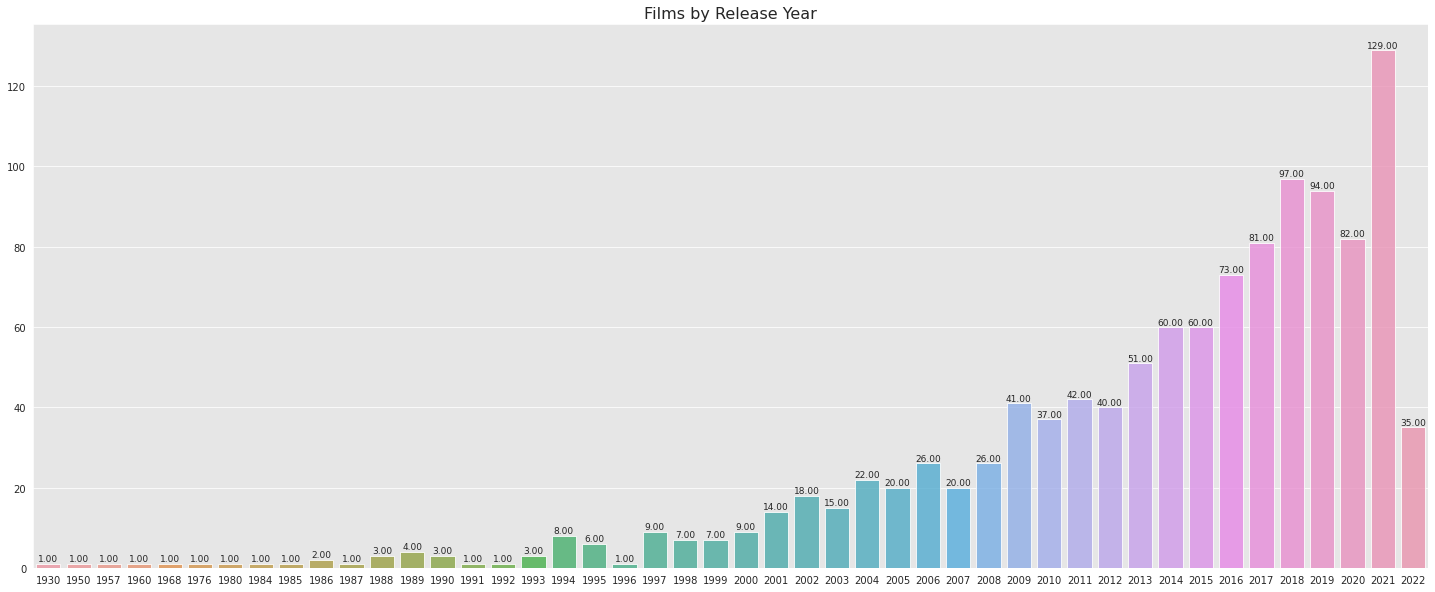

In [209]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
year = df['Year'].value_counts()
plt.figure(figsize=(25,10))
baryear = sns.barplot(year.index, year.values, alpha=0.8)
plotVer(baryear)
plt.title('Films by Release Year',fontsize=16)
plt.show()

### Average Rating Film by Release Year

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


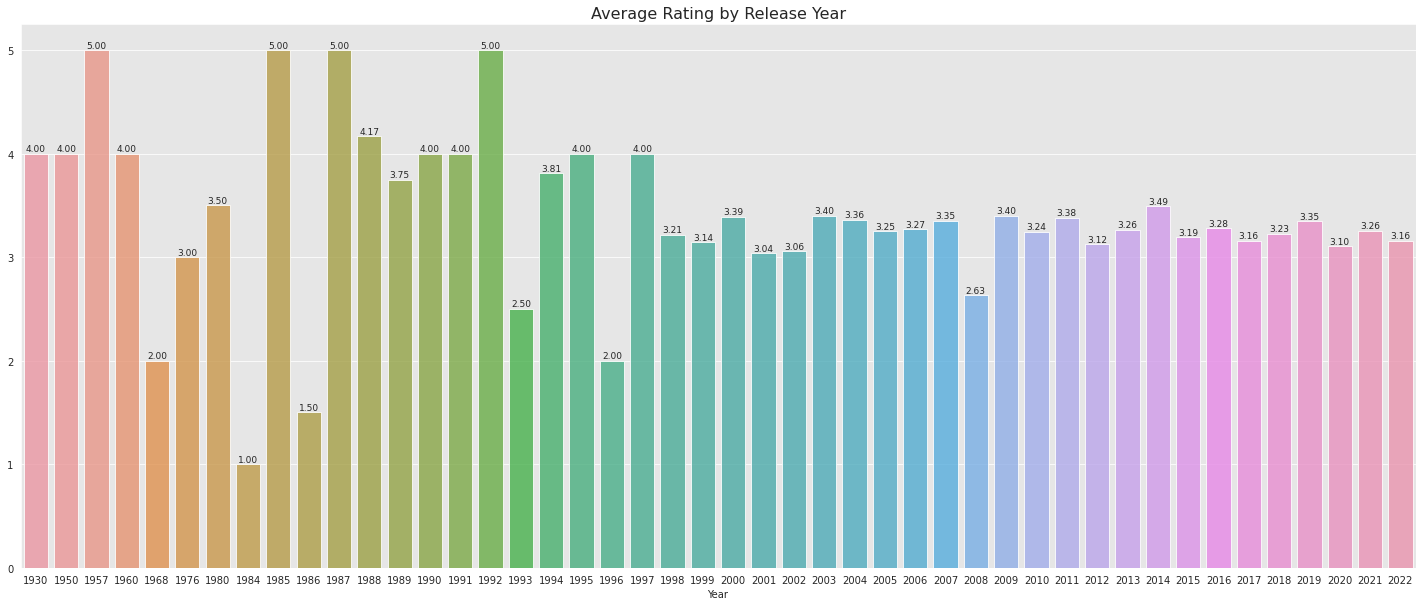

In [234]:
ratings = df.groupby('Year')['Rating'].mean()
plt.figure(figsize=(25,10))
barrat = sns.barplot(ratings.index, ratings.values, alpha=0.8)
plotVer(barrat)
plt.title('Average Rating by Release Year',fontsize=16)
plt.show()

### Most Watched Directors

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


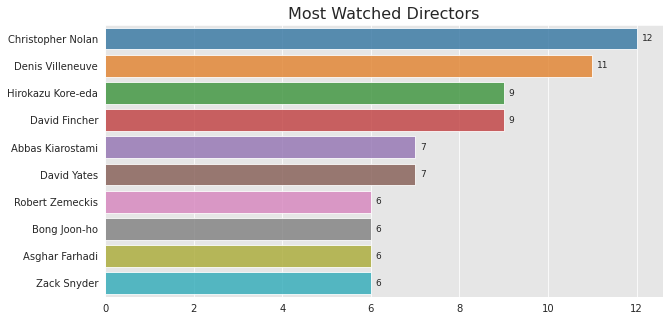

In [236]:
dir = df['Director'].value_counts()[:10]
plt.figure(figsize=(10,5))
bardir = sns.barplot(dir.values, dir.index, alpha=0.8)
plotHor(bardir)
plt.title('Most Watched Directors',fontsize=16 )
plt.show()

### Most Watched Actors

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


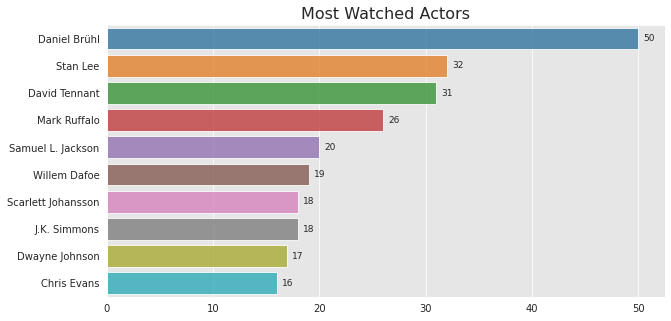

In [237]:
actor = (", ".join(df["Cast"]).split(', '))
act = Counter(actor)

y = [count for tag, count in act.most_common(10)]
x = [tag for tag, count in act.most_common(10)]

plt.figure(figsize=(10,5))
baractor = sns.barplot(y, x, alpha=0.8)
plotHor(baractor)
plt.title('Most Watched Actors',fontsize=16 )
plt.show()

### Most Watched Genre

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


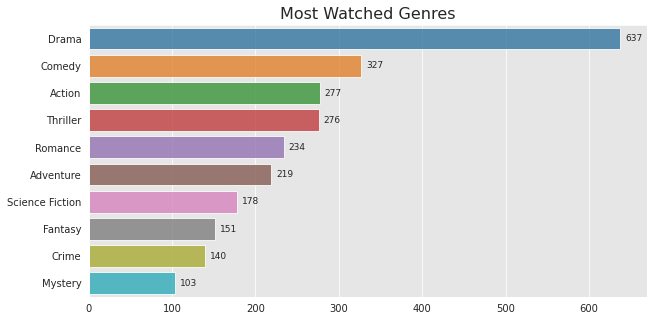

In [239]:
genre = (", ".join(df["Genre"]).split(', '))
gr = Counter(genre)

y = [count for tag, count in gr.most_common(10)]
x = [tag for tag, count in gr.most_common(10)]

plt.figure(figsize=(10,5))
bargenre = sns.barplot(y, x, alpha=0.8)
plotHor(bargenre)
plt.title('Most Watched Genres',fontsize=16 )
plt.show()

### Most Watched Languages

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


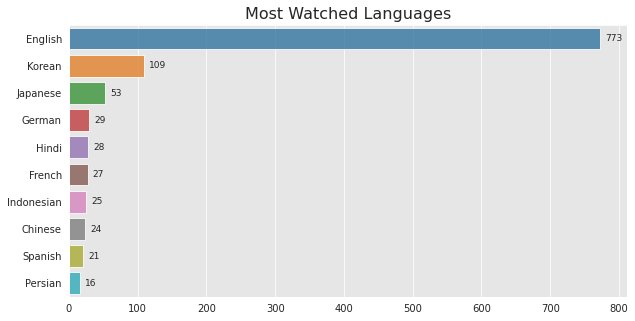

In [240]:
lang = df['Lang'].value_counts()[:10]
plt.figure(figsize=(10,5))
barlang = sns.barplot(lang.values, lang.index, alpha=0.8)
plotHor(barlang)
plt.title('Most Watched Languages',fontsize=16 )
plt.show()

### Summary 

In [241]:
director = str(len(df['Director'].value_counts()))
hours = str(int((df['Runtime'].sum(axis = 0, skipna = True)) // 60))
film = str(len(df))

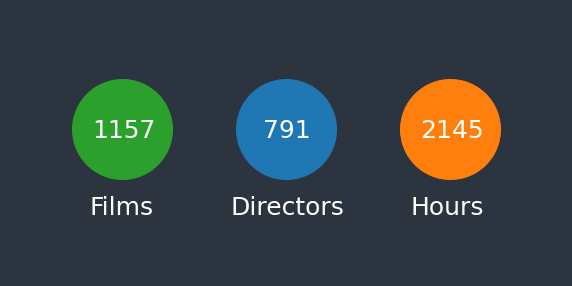

In [242]:
fig = plt.figure(figsize=(10,5))
fig.patch.set_facecolor('#2c3440')

plt.scatter( 0 , 0.1 , s = 10000 )
plt.text(-0.07, 0.037, director, fontsize = 25, color = 'w')
plt.text(-0.17, -0.5, 'Directors', fontsize = 25, color = 'w')

plt.scatter( 0.5 , 0.1 , s = 10000 )
plt.text(0.407, 0.037, hours, fontsize = 25, color = 'w')
plt.text(0.38, -0.5, 'Hours', fontsize = 25, color = 'w')

plt.scatter( -0.5 , 0.1 , s = 10000 )
plt.text(-0.59, 0.037, film, fontsize = 25, color = 'w')
plt.text(-0.6, -0.5, 'Films', fontsize = 25, color = 'w')

plt.xlim( -0.85 , 0.85 )
plt.ylim( -0.95 , 0.95 )

plt.axis('off')
plt.show()